# DEEP LEARNING
### TOPIC : DOGS V/S CATS IMAGE CLASSIFICATION USING CNN, VGG-16 AND VGG-19

## PART 1 : USING ```CNN``` MODEL
### INTRODUCTION
![catanddog](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

This is a image classification project from our team. In this project, we applied ```Convolutional Neural Network``` for image classification.
The training archive contains 25,000 images of dogs and cats. Train the algorithm on these files and predict the labels
(1 = dog, 0 = cat).

### IMPORT MODULES

In [18]:
# For general use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
# For CNN, image processing and image format.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
import seaborn as sns
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import cv2
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
warnings.filterwarnings('ignore')

### DOWNLOAD THE DATASET

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

### UNZIP THE DATASET

In [ ]:
!unzip kagglecatsanddogs_3367a.zip

### CREATE DATAFRAME FOR INPUT AND OUTPUT

In [19]:
# For saving the resulting files in the drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/PetImages/Cat/9096.jpg 0


In [21]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac = 1).reset_index(drop = True)
df.head()

,images,label
0,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1
1,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1
2,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,0
3,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1
4,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1


### IDENTIFYING AND REMOVING INVALID AND NON IMAGE FILES

In [22]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

In [23]:
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

[]

In [24]:
# Delete db files
df = df[df['images'] != 'PetImages/Dog/Thumbs.db']
df = df[df['images'] != 'PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

# Identifying if the invalid images are still present in the dataframe
folder_path = "PetImages"
extensions = []
corupt_img_paths = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end = "\r", flush = True)
        try:
            im = Image.open(file_path)
        except:
            print(file_path)
            corupt_img_paths.append(file_path)
            continue
        else:
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])
len(df)

25000

### EXPLORATORY DATA ANALYSIS

In [25]:
# To display grid of images
plt.figure(figsize = (25, 25))
temp = df[df['label'] == 1]['images']
start = random.randint(0, len(temp))
files = temp[start : start + 25]

for index, file in enumerate(files):
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# To display grid of images
plt.figure(figsize = (25, 25))
temp = df[df['label'] == 0]['images']
start = random.randint(0, len(temp))
files = temp[start : start + 25]

for index, file in enumerate(files):
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

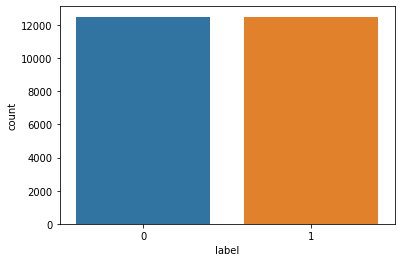

In [27]:
sns.countplot(df['label'])

### CREATE DATA GENERATOR FOR THE IMAGES

In [28]:
df['label'] = df['label'].astype('str')

In [29]:
df.head()

,images,label
0,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1
1,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1
2,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,0
3,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1
4,drive/My Drive/ASSIGNMENT-PROJECT/MI PROJECT/P...,1


### TEST AND TRAIN SPLIT OF DATA

In [30]:
# Input Test and Train Split (80/20)

train, test = train_test_split(df, test_size = 0.2, random_state = 42)

### TEST AND TRAIN GENERATORS <br>
![ImageGenerator](https://www.pyimagesearch.com/wp-content/uploads/2019/07/keras_data_augmentation_in_place.png)

In [31]:
# Building the test and train generators
train_generator = ImageDataGenerator(
    rescale = 1./255,  # Normalization of images
    rotation_range = 40, # Augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col = 'images', 
    y_col = 'label', 
    target_size = (128,128), 
    batch_size = 512, 
    class_mode = 'binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col = 'images', 
    y_col = 'label', 
    target_size = (128,128), 
    batch_size = 512, 
    class_mode = 'binary'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### MODEL CREATION OF CONVOLUTIONAL NEURAL NETWORKS
#### BUILD NETWORK

The architecture of CNN used in this project is shown as follow (PS: fully connected network is not shown on the picture):
![mynetwork](https://raw.githubusercontent.com/patrick013/Image-Classification-CNN-and-VGG/master/pictures/mycnnmodel.png)

In [32]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding = 'same',activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Conv2D(16, (3, 3), padding = 'same',activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, (3, 3), padding = 'same',activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Conv2D(64, (3, 3), padding = 'same',activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))

  opt = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer = opt,
              loss='binary_crossentropy', # loss = 'categorical_crossentropy' if softmax
              metrics = ['accuracy'])

  return model

In [33]:
model = My_CNNmodel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)      

### TRAINING THE MODEL

In [34]:
history = model.fit(train_iterator, epochs = 30, validation_data = val_iterator)

Epoch 1/30
40/40 [==============================] - 165s 4s/step - loss: 0.6868 - accuracy: 0.5540 - val_loss: 0.6495 - val_accuracy: 0.6164
Epoch 2/30
40/40 [==============================] - 157s 4s/step - loss: 0.6237 - accuracy: 0.6478 - val_loss: 0.5675 - val_accuracy: 0.7064
Epoch 3/30
40/40 [==============================] - 156s 4s/step - loss: 0.5791 - accuracy: 0.6965 - val_loss: 0.5564 - val_accuracy: 0.7028
Epoch 4/30
40/40 [==============================] - 156s 4s/step - loss: 0.5563 - accuracy: 0.7121 - val_loss: 0.5015 - val_accuracy: 0.7476
Epoch 5/30
40/40 [==============================] - 154s 4s/step - loss: 0.5289 - accuracy: 0.7345 - val_loss: 0.5050 - val_accuracy: 0.7534
Epoch 6/30
40/40 [==============================] - 154s 4s/step - loss: 0.5064 - accuracy: 0.7518 - val_loss: 0.4702 - val_accuracy: 0.7756
Epoch 7/30
40/40 [==============================] - 153s 4s/step - loss: 0.4866 - accuracy: 0.7647 - val_loss: 0.4461 - val_accuracy: 0.7862
Epoch 8/30
40

### VISUALIZATION OF RESULTS : CONFUSION MATRIX, CLASSIFICATION OF REPORTS AND GRAPHS

Test: accuracy = 0.856600  ;  loss = 0.334920 


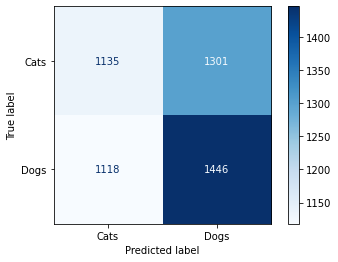

In [35]:
# Evaluating the Model
loss, accuracy = model.evaluate_generator(val_iterator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
y_pred =  model.predict_generator(val_iterator)
y_p = np.where(y_pred > 0.5, 1,0)
y_test = (val_iterator)
cm = confusion_matrix(y_test.classes, y_p)
labels = ["Cats", "Dogs"]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)

disp.plot(cmap = plt.cm.Blues)
plt.show()


In [36]:
# Generate a classification report
report = classification_report(y_test.classes, y_p, target_names = ['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.50      0.47      0.48      2436
           1       0.53      0.56      0.54      2564

    accuracy                           0.52      5000
   macro avg       0.52      0.51      0.51      5000
weighted avg       0.52      0.52      0.52      5000



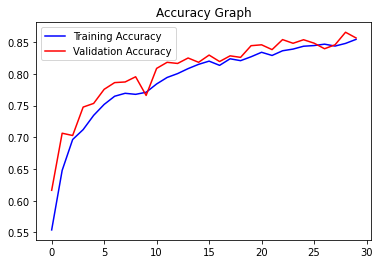

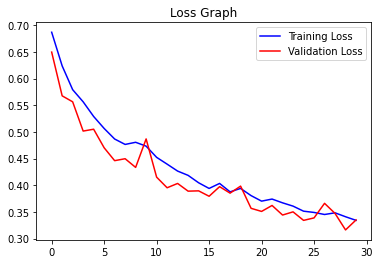

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

### PREDICTING ```CAT``` OR ```DOG``` WITH RANDOM IMAGES

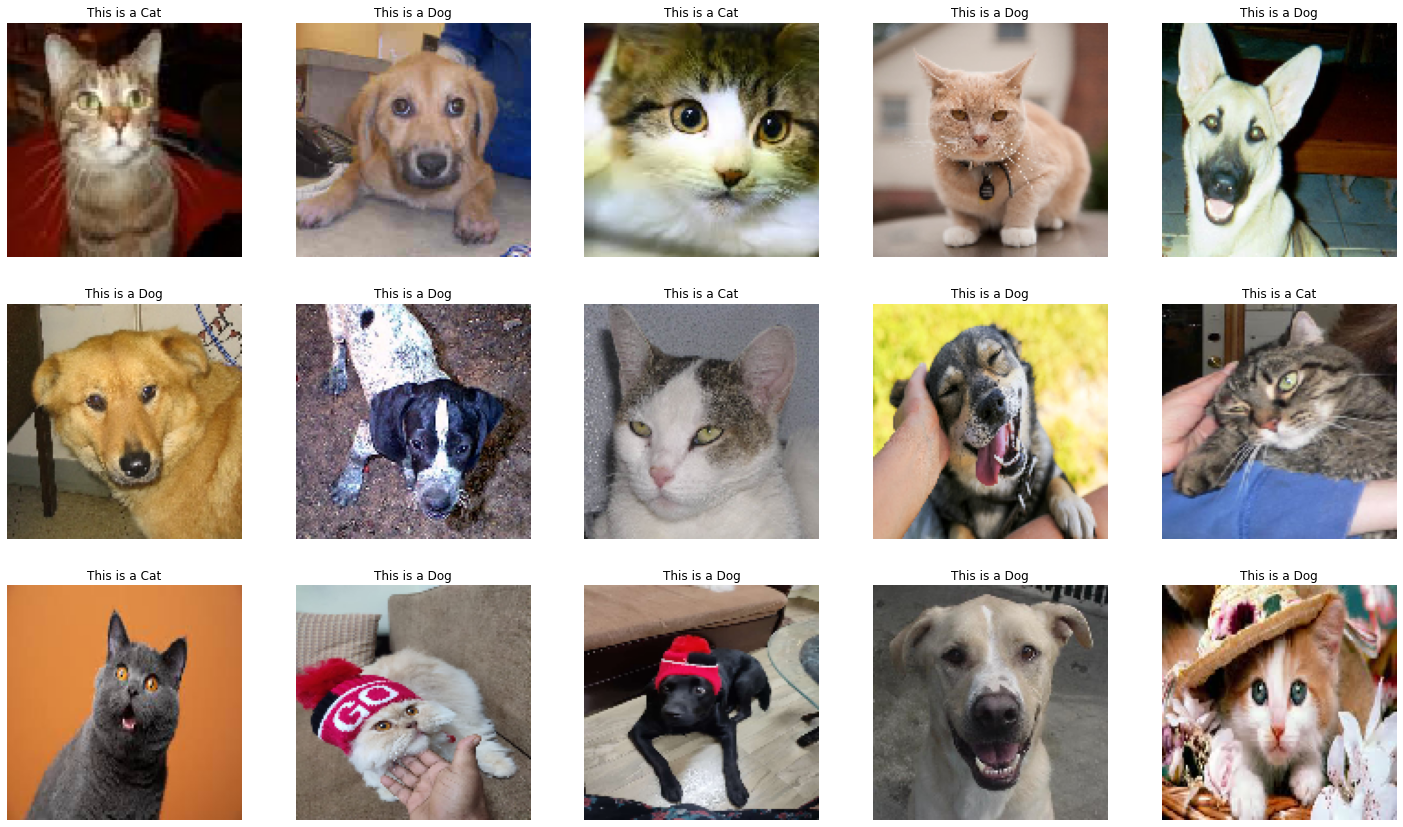

In [39]:
# Saving Model for easy access
model.save('CNN_MODEL.h5')
model.save_weights('CNN_MODEL_WEIGHTS.h5')

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
rows = 5
columns = 5

fig = plt.figure(figsize = (25, 25))
for i in range(1, 16):
  fig.add_subplot(rows, columns, i)
  img = image.load_img('TestImages/{}.jpg'.format(i), target_size = (128,128))
  plt.imshow(img)
  plt.axis('off')
  x = image.img_to_array(img)
  x = x / .255
  x = np.expand_dims(x, axis = 0)
  images = np.vstack([x])
  #val = model1.predict(images)
  y_pred1 =  model.predict_generator(images)
  val = np.where(y_pred1 > 0.5, 1,0)
  # print("val",val)
  if val == 0:
    title1 = "This is a Cat"
    plt.title(title1)
    # print("Cat")
  else:
    title1 = "This is a Dog"
    plt.title(title1)
    # print("Dog")
plt.show()


### SUMMARY
- The accuracy of the CNN model would have increased , if number of epochs were made a little higher.
- Overfitting and underfitting are avoided by using the data augmentation, normalization as did above.
- An improvement to this model is VGG which is done in the next file.

THANK YOU !!!